[Data](http://www.thumos.info/download.html)

In [1]:
import torch
import os
import json
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda

class CustomVideoDataset(Dataset):
    def __init__(self, vid_dir, transform=None, target_transform=None):
        self.vid_labels = os.listdir(vid_dir)
        self.vid_dir = vid_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.vid_labels)

    def __getitem__(self, idx):
        vid_data = os.path.join(self.vid_dir, self.vid_labels[idx])
        label = self.vid_labels[idx]
        if self.transform:
            vid_data = self.transform(vid_data)
        if self.target_transform:
            label = self.target_transform(annotationToNum(label.split("_")[1]))
        return vid_data, label

annotation_list = ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress', 'Biking', 'Billiards', 'BlowDryHair', 'BlowingCandles', 'BodyWeightSquats', 'Bowling', 'BoxingPunchingBag', 'BoxingSpeedBag', 'BreastStroke', 'BrushingTeeth', 'CleanAndJerk', 'CliffDiving', 'CricketBowling', 'CricketShot', 'CuttingInKitchen', 'Diving', 'Drumming', 'Fencing', 'FieldHockeyPenalty', 'FloorGymnastics', 'FrisbeeCatch', 'FrontCrawl', 'GolfSwing', 'Haircut', 'Hammering', 'HammerThrow', 'HandstandPushups', 'HandstandWalking', 'HeadMassage', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'IceDancing', 'JavelinThrow', 'JugglingBalls', 'JumpingJack', 'JumpRope', 'Kayaking', 'Knitting', 'LongJump', 'Lunges', 'MilitaryParade', 'Mixing', 'MoppingFloor', 'Nunchucks', 'ParallelBars', 'PizzaTossing', 'PlayingCello', 'PlayingDaf', 'PlayingDhol', 'PlayingFlute', 'PlayingGuitar', 'PlayingPiano', 'PlayingSitar', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'Rafting', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'ShavingBeard', 'Shotput', 'SkateBoarding', 'Skiing', 'Skijet', 'SkyDiving', 'SoccerJuggling', 'SoccerPenalty', 'StillRings', 'SumoWrestling', 'Surfing', 'Swing', 'TableTennisShot', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'Typing', 'UnevenBars', 'VolleyballSpiking', 'WalkingWithDog', 'WallPushups', 'WritingOnBoard', 'YoYo']

def annotationToNum(annotation):
    return annotation_list.index(annotation)

def numToAnnotation(num):
    return annotation_list[num]

vid_dir = "C://Users//menez//Documents//VSCode//MLPlayground//VideoClassification//data//UCF101_videos//UCF101"

In [2]:
with open("data/kinetics_classnames.json", "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [3]:
from pytorchvideo.data.encoded_video import EncodedVideo

from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample
)

class SlowTransfrom(object):
    def __init__(self):
        side_size = 256
        mean = [0.45, 0.45, 0.45]
        std = [0.225, 0.225, 0.225]
        crop_size = 256
        num_frames = 8
        sampling_rate = 8
        frames_per_second = 30

        # Note that this transform is specific to the slow_R50 model.
        self.transform =  ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames),
                    Lambda(lambda x: x/255.0),
                    NormalizeVideo(mean, std),
                    ShortSideScale(
                        size=side_size
                    ),
                    CenterCropVideo(crop_size=(crop_size, crop_size))
                ]
            ),
        )

        # The duration of the input clip is also specific to the model.
        self.clip_duration = (num_frames * sampling_rate)/frames_per_second

    def __call__(self, video_path):

        # Select the duration of the clip to load by specifying the start and end duration
        # The start_sec should correspond to where the action occurs in the video
        start_sec = 0
        end_sec = start_sec + self.clip_duration

        # Initialize an EncodedVideo helper class
        video = EncodedVideo.from_path(video_path)

        # Load the desired clip
        video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

        # Apply a transform to normalize the video input
        video_data = self.transform(video_data)

        # Move the inputs to the desired device
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        inputs = video_data["video"]
        inputs = inputs.to(device)[None, ...]

        return inputs

c:\Users\menez\Documents\VSCode\MLPlayground\.venv\Lib\site-packages\torchvision\transforms\_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
c:\Users\menez\Documents\VSCode\MLPlayground\.venv\Lib\site-packages\torchvision\transforms\_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
c:\Users\menez\Documents\VSCode\MLPlayground\.venv\Lib\site-packages\torchvision\transforms\functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.trans

In [4]:
generator = torch.Generator().manual_seed(42)

# Datasets
training_data = CustomVideoDataset(vid_dir, target_transform=Lambda(lambda y: torch.zeros(101, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

slow_transform = SlowTransfrom()
slow_data = CustomVideoDataset(vid_dir, transform=slow_transform, target_transform=Lambda(lambda y: torch.zeros(101, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
slow_training_data, slow_testing_data = torch.utils.data.random_split(slow_data, [0.8, 0.2], generator=generator)

In [5]:
# Dataloaders
batch_size = 2 # 64

# Create data loaders.
slow_train_dataloader = DataLoader(slow_training_data, batch_size=batch_size)
slow_test_dataloader = DataLoader(slow_testing_data, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


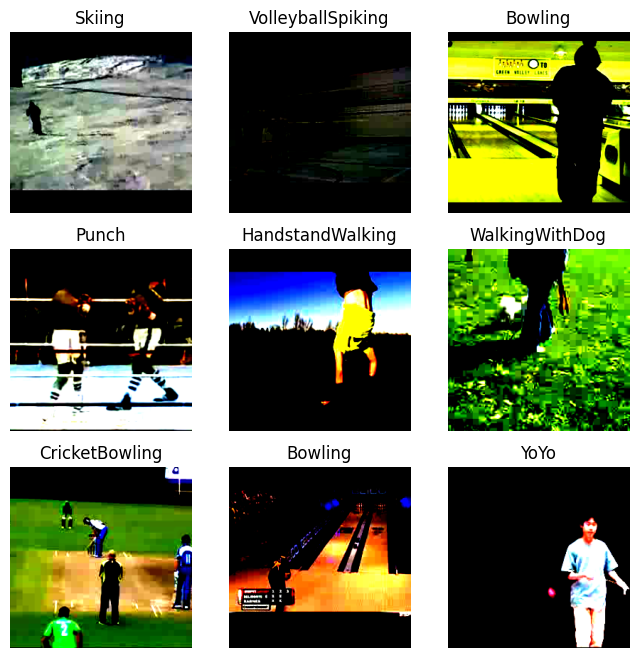

In [6]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# note: clipping notice results from the image tensor being normalized 
# to values outside the expected image format. i.e. nomalized values are
# good for learning but not for viewing

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(slow_training_data), size=(1,)).item()
    video, label = slow_training_data[sample_idx]
    # img = video[0]
    # print(video[0, :, 0, :, :].shape)
    # print(video[0, :, 0, :, :])
    img = video[0, :, 0, :, :].permute(1, 2, 0)
    label = numToAnnotation(label.argmax().item())
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.cpu().squeeze(), cmap="gray")
plt.show()

[3D Resnet Model](https://pytorch.org/hub/facebookresearch_pytorchvideo_resnet/)

In [7]:
import torch
# Choose the `slow_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)

# Set to GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.eval()
model = model.to(device)

Using cache found in C:\Users\menez/.cache\torch\hub\facebookresearch_pytorchvideo_main


Slow Inference

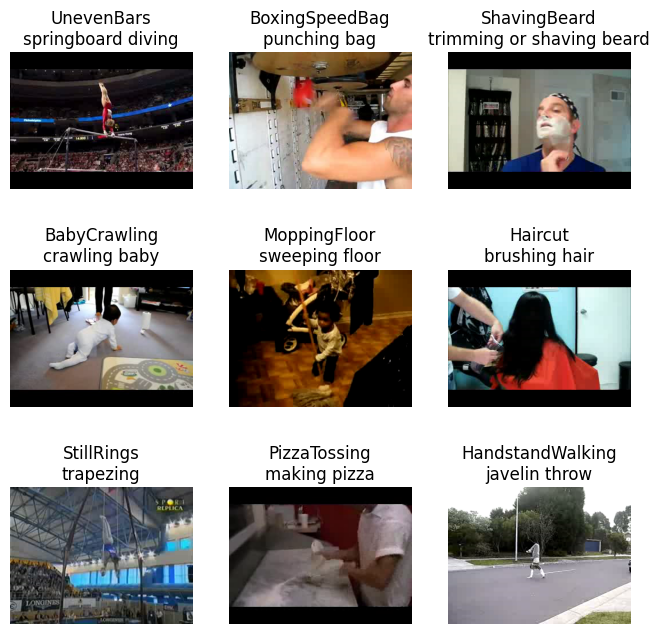

In [8]:
from torchvision.io import read_video

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # grabbing a random example (uri, label) from the UCF dataset
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    video_data, realLabel = training_data[sample_idx]
    img = read_video(video_data, pts_unit='sec')[0][0]
    realLabel = numToAnnotation(realLabel.argmax().item())

    # using sample_idx to convert grabbed exmaple to corresponding
    # input for slow video. Equivalent to using grabbed uri and
    # running the slow_transform
    slow_video_data = slow_transform(video_data)

    # Pass the input clip through the model
    preds = model(slow_video_data)

    # Get the predicted classes
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=1).indices

    # Map the predicted classes to the label names
    pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes[0]]
    # print("Predicted labels: %s" % ", ".join(pred_class_names))

    label = realLabel + "\n" + pred_class_names[0]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/video_classifier_experiment_1')

# Load the example video
video_path = "data/archery.mp4"

writer.add_graph(model, slow_transform(video_path))
writer.close()

In [10]:
model.blocks[5]

ResNetBasicHead(
  (pool): AvgPool3d(kernel_size=(8, 7, 7), stride=(1, 1, 1), padding=(0, 0, 0))
  (dropout): Dropout(p=0.5, inplace=False)
  (proj): Linear(in_features=2048, out_features=400, bias=True)
  (output_pool): AdaptiveAvgPool3d(output_size=1)
)

Fine Tuning

In [11]:
# Changing the output from 400 to 101
model.blocks[5].proj = torch.nn.Linear(2048, 101, bias=True)

In [12]:
model.blocks[5]

ResNetBasicHead(
  (pool): AvgPool3d(kernel_size=(8, 7, 7), stride=(1, 1, 1), padding=(0, 0, 0))
  (dropout): Dropout(p=0.5, inplace=False)
  (proj): Linear(in_features=2048, out_features=101, bias=True)
  (output_pool): AdaptiveAvgPool3d(output_size=1)
)

In [13]:
# Set to GPU or CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.train()
model = model.to(device)

In [14]:
device

'cuda'

In [15]:
plst = [
    {'params': model.blocks[5].parameters(), 'lr': 1e-3}
]

Declaring loss function and optimizer

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(plst, lr=1e-3)

Training the model

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.squeeze())
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Testing the model

In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.squeeze())
            test_loss += loss_fn(pred, y).item()
            # print(pred.argmax(1))
            # print(y.argmax(1))
            # print(pred.argmax(1) == y.argmax(1))
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [19]:
torch.cuda.empty_cache()

Running the model and testing after each epoch

In [20]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(slow_train_dataloader, model, loss_fn, optimizer)
    test(slow_test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 4.635925  [    2/10656]
loss: 4.491583  [  202/10656]
loss: 4.628922  [  402/10656]
loss: 4.518029  [  602/10656]
loss: 4.622621  [  802/10656]
loss: 4.189735  [ 1002/10656]
loss: 4.371144  [ 1202/10656]
loss: 4.422391  [ 1402/10656]
loss: 4.499185  [ 1602/10656]
loss: 4.524201  [ 1802/10656]
loss: 4.189590  [ 2002/10656]
loss: 3.992151  [ 2202/10656]
loss: 4.644600  [ 2402/10656]
loss: 4.239169  [ 2602/10656]
loss: 4.056748  [ 2802/10656]
loss: 4.587589  [ 3002/10656]
loss: 3.747743  [ 3202/10656]
loss: 4.154992  [ 3402/10656]
loss: 4.544795  [ 3602/10656]
loss: 4.046935  [ 3802/10656]
loss: 4.201797  [ 4002/10656]
loss: 4.074937  [ 4202/10656]
loss: 3.966907  [ 4402/10656]
loss: 4.152857  [ 4602/10656]
loss: 4.045895  [ 4802/10656]
loss: 3.862784  [ 5002/10656]
loss: 4.359094  [ 5202/10656]
loss: 3.535210  [ 5402/10656]
loss: 3.745308  [ 5602/10656]
loss: 4.092387  [ 5802/10656]
loss: 3.696151  [ 6002/10656]
loss: 3.662697  [ 6202/10656]


Saving the model

In [21]:
torch.save(model.state_dict(), "slow_model_ft.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Redoing Slow Inference (Fine Tuned)

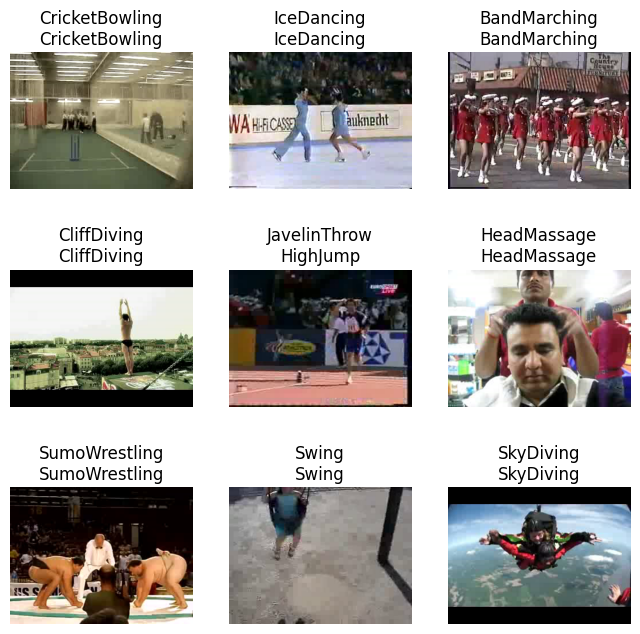

In [23]:
from torchvision.io import read_video

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    # grabbing a random example (uri, label) from the UCF dataset
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    video_data, realLabel = training_data[sample_idx]
    img = read_video(video_data, pts_unit='sec')[0][0]
    realLabel = numToAnnotation(realLabel.argmax().item())

    # using sample_idx to convert grabbed exmaple to corresponding
    # input for slow video. Equivalent to using grabbed uri and
    # running the slow_transform
    slow_video_data = slow_transform(video_data)

    # Pass the input clip through the model
    preds = model(slow_video_data)

    # Get the predicted classes
    post_act = torch.nn.Softmax(dim=1)
    preds = post_act(preds)
    pred_classes = preds.topk(k=1).indices

    # Map the predicted classes to the label names
    pred_class_names = [numToAnnotation(int(i)) for i in pred_classes[0]]
    # print("Predicted labels: %s" % ", ".join(pred_class_names))

    label = realLabel + "\n" + pred_class_names[0]

    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()